# Module Import

## Module Version

|Library|Version|
|-----|------|
|numpy|1.23.4|
|pandas|1.5.1|
|matplotlib|3.6.2|
|seaborn|0.12.1|
|scikit-learn|1.1.3|
|imbalanced-learn|0.9.1|
|xgboost|1.7.1|
|lightgbm|3.3.3|
|optuna|2.10.1|
|tqdm|4.64.1|

In [175]:
from sklearn.decomposition import PCA # 차원축소
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

from imblearn.under_sampling import * # 임벨런스
from imblearn.over_sampling import * # 임벨런스
from imblearn.combine import * # 임벨런스

import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from jtlearn import Preprocessing
from ensemble import BinaryCalssifier, Regressor

## Load Data

In [176]:
# Load Data
save_path = 'submission/'
base_path = 'data/'

train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

# Preprocessing

1. Fill/Drop Null data
2. Standard Scaling
3. Ordinal Encoding

In [177]:
train = train.fillna(train.mean())

X = train.drop(columns=["ID", "Y_LABEL"])
y = train["Y_LABEL"]
test = test.drop(columns=['ID'])

train_num_cols = X.drop(columns=['COMPONENT_ARBITRARY']).columns.tolist()
test_num_cols = test.drop(columns=['COMPONENT_ARBITRARY']).columns.tolist()

ss = StandardScaler()
ss2 = StandardScaler()

ss2.fit(X[test_num_cols])
X[train_num_cols] = ss.fit_transform(X[train_num_cols])
test[test_num_cols] = ss2.transform(test[test_num_cols])

X.COMPONENT_ARBITRARY = X.COMPONENT_ARBITRARY.map({"COMPONENT1" : 1, "COMPONENT2" : 2, "COMPONENT3" : 3, "COMPONENT4" : 4})
test.COMPONENT_ARBITRARY = test.COMPONENT_ARBITRARY.map({"COMPONENT1" : 1, "COMPONENT2" : 2, "COMPONENT3" : 3, "COMPONENT4" : 4})

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=172)
X_test = X_test[test.columns]

In [178]:
test

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,1,-0.226304,0.592112,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,-0.311651,-0.041588,-0.250456,-0.400998,-0.191804,-0.265133,-0.102635,-0.10655,-0.363951,0.944762
1,3,-0.083512,-0.669043,-0.340760,-0.150214,-0.089633,-0.045445,-0.260252,0.187233,-0.041588,0.019051,-0.400998,-0.191804,1.516121,0.042348,-0.10655,0.353638,-1.084484
2,2,-0.276115,-0.921274,-0.340760,-0.150214,-0.089633,-0.115388,-0.143932,-0.324780,-0.041588,-0.250456,-0.400998,-0.191804,-0.264479,-0.102635,-0.10655,-1.311328,0.235748
3,3,-0.413213,-1.173506,-0.340760,-0.150214,-0.089633,-0.010473,-0.236988,-0.028450,-0.041588,0.108886,-0.350857,-0.191804,4.968037,-0.102635,-0.10655,0.674134,-0.930269
4,2,1.204694,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,-0.221479,-0.309776,-0.041588,-0.250456,-0.400998,-0.191804,-0.261207,-0.102635,-0.10655,-0.926330,-0.225017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3,-0.339683,0.087650,-0.340760,-0.150214,-0.089633,-0.010473,0.740102,1.629495,-0.041588,5.588859,-0.317430,0.333602,1.036452,-0.102635,-0.10655,-0.769106,1.080171
6037,3,0.233617,0.592112,-0.340760,-0.150214,-0.089633,0.059471,-0.252497,1.046214,-0.041588,0.198722,-0.400998,-0.191804,0.181816,-0.102635,-0.10655,0.573349,-1.082603
6038,3,0.279633,0.087650,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,-0.234755,-0.041588,-0.250456,-0.400998,-0.191804,-0.226524,-0.102635,-0.10655,3.887155,-1.082603
6039,2,-0.422701,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,0.212784,-0.330406,-0.041588,-0.250456,-0.400998,-0.191804,-0.268405,-0.102635,-0.10655,-1.174261,-0.208091


In [179]:
y

4972     0
1361     0
12660    0
7785     0
1287     0
        ..
8829     0
6478     0
12191    0
4418     0
13082    0
Name: Y_LABEL, Length: 11276, dtype: int64

# Regression
## Multicollinearity

In [180]:
empty_cols = X.drop(columns=test.columns).columns
X_reg = X[test.columns]

for col in empty_cols:
    y_reg = X[col]
    X_reg['intercept'] = 1
    lm = sm.OLS(y_reg, X_reg)
    results = lm.fit()

    print(f"***************************** {col} *****************************\n")
    print(results.summary())

X_reg = X_reg.drop(columns=['intercept'])

***************************** SAMPLE_TRANSFER_DAY *****************************

                             OLS Regression Results                            
Dep. Variable:     SAMPLE_TRANSFER_DAY   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.013
Method:                  Least Squares   F-statistic:                     9.252
Date:                 Fri, 25 Nov 2022   Prob (F-statistic):           7.17e-26
Time:                         10:44:48   Log-Likelihood:                -15419.
No. Observations:                11276   AIC:                         3.088e+04
Df Residuals:                    11257   BIC:                         3.102e+04
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

                            OLS Regression Results                            
Dep. Variable:                     BE   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.130
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           8.89e-09
Time:                        10:44:48   Log-Likelihood:                -16244.
No. Observations:               11276   AIC:                         3.253e+04
Df Residuals:                   11257   BIC:                         3.267e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
COMPONENT_ARBITRARY    -0.0277    

                            OLS Regression Results                            
Dep. Variable:           FOPTIMETHGLY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.211
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.241
Time:                        10:44:48   Log-Likelihood:                -15551.
No. Observations:               11276   AIC:                         3.114e+04
Df Residuals:                   11257   BIC:                         3.128e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
COMPONENT_ARBITRARY     0.0115    

***************************** K *****************************

                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     336.1
Date:                Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:44:49   Log-Likelihood:                -14578.
No. Observations:               11276   AIC:                         2.919e+04
Df Residuals:                   11257   BIC:                         2.933e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      P   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     123.0
Date:                Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:44:49   Log-Likelihood:                -14962.
No. Observations:               11276   AIC:                         2.996e+04
Df Residuals:                   11257   BIC:                         3.010e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
COMPONENT_ARBITRARY     0.2129    

***************************** U100 *****************************

                            OLS Regression Results                            
Dep. Variable:                   U100   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.679
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0354
Time:                        10:44:49   Log-Likelihood:                -14472.
No. Observations:               11276   AIC:                         2.898e+04
Df Residuals:                   11257   BIC:                         2.912e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

***************************** U6 *****************************

                            OLS Regression Results                            
Dep. Variable:                     U6   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2827
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.999
Time:                        10:44:49   Log-Likelihood:                -16804.
No. Observations:               11276   AIC:                         3.365e+04
Df Residuals:                   11257   BIC:                         3.378e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [181]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_reg.values, i) for i in range(len(X_reg.columns))]
vif["features"] = X_reg.columns
vif

,VIF Factor,features
0,1.053620,COMPONENT_ARBITRARY
1,1.014226,ANONYMOUS_1
2,1.104152,YEAR
3,1.024778,ANONYMOUS_2
4,1.019504,AG
5,1.321325,CO
6,1.306786,CR
7,1.403418,CU
8,2.012272,FE
9,1.269394,H2O


In [182]:
X_reg

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
4972,3,-0.400879,0.087650,-0.340760,-0.150214,-0.089633,-0.080416,-0.268007,-0.257262,-0.041588,-0.250456,-0.367571,-0.191804,-0.169592,-0.102635,-0.10655,0.881750,-1.056274
1361,1,-0.083512,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,-0.321029,-0.041588,-0.250456,3.359544,-0.191804,-0.258589,-0.102635,-0.10655,-0.369998,1.168562
12660,1,-0.416297,0.339881,0.295608,-0.150214,-0.089633,-0.115388,-0.252497,-0.309776,-0.041588,-0.250456,0.484819,-0.191804,-0.268405,-0.102635,-0.10655,-0.275260,1.200534
7785,1,1.357210,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,-0.315402,-0.041588,-0.250456,3.593534,-0.191804,-0.267751,-0.102635,-0.10655,0.226649,1.505203
1287,1,-0.468480,-0.416812,-0.029849,-0.150214,-0.089633,-0.115388,-0.190460,-0.274141,-0.041588,-0.070785,0.518246,-0.191804,-0.267096,-0.102635,-0.10655,-0.285338,1.110261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,3,-0.255479,0.087650,-0.340760,-0.150214,-0.089633,0.024499,-0.236988,0.592342,-0.041588,0.108886,-0.400998,0.070899,-0.043949,0.187332,-0.10655,0.742667,-1.088245
6478,3,0.992641,0.087650,-0.340760,-0.150214,-0.089633,0.024499,-0.252497,0.217241,-0.041588,0.198722,-0.384284,-0.191804,11.260013,-0.102635,-0.10655,0.793060,-1.048751
12191,2,-0.172935,-0.921274,-0.340760,-0.150214,-0.089633,-0.115388,0.740102,-0.300398,-0.041588,-0.250456,-0.400998,-0.191804,-0.265787,-0.102635,-0.10655,-1.307297,0.263958
4418,2,-0.410841,-1.425737,0.411972,-0.150214,-0.089633,-0.080416,0.298085,-0.307900,-0.041588,-0.250456,-0.384284,-0.191804,-0.258589,-0.102635,-0.10655,-0.936409,-0.268272


## regressor hyper parameters

{
    
    "metric": , # 평가지표(default='r2_score')
    
    "learner": , # 학습모델['rf', 'xgb', 'lgbm'] 중 아무 조합 선택 ㄱㄱ(default=['rf', 'xgb', 'lgbm'])
    
    "ensemble": , # ['voting', 'stacking'](default='voting')
    
    "learning_rate": , # 학습률(default=0.05)
    
    "random_state": , # 난수 seed(default=42)
    
    "early_stopping_rounds": , # overfitting 방지용(default=10)
    
    "optimize": , # optuna 사용할지 말지 True or False 사용 ㄱㄱ(default=False)
    
    "n_trials": , # optuna 횟수(default=20)
    
    "cv": , # K-fold CV의 K(default=5)
    
    "N": , # voting에서 모델별 weights의 조합가지수(default=5)
    
}

## Find Best Regressor For Each Column

In [183]:
learners = [['rf']]
# learners = [['rf'], ['xgb'], ['lgbm'],
#             ['rf', 'xgb'], ['rf', 'lgbm'], ['xgb', 'lgbm'], 
#             ['rf', 'xgb', 'lgbm']]

reg_dict = {}

df_score_train = pd.DataFrame([[0]*len(empty_cols)]*len(learners))
df_score_train.columns = empty_cols
df_score_train.index = ['+'.join(learner) for learner in learners]

df_score_val = copy.deepcopy(df_score_train)
print("empty column length is", len(empty_cols))

for col in empty_cols:
    reg_list = []
    score_list = []
    temp_score_val = []
    print(f"************************* {col} *************************\n")
    for learner in learners:
        print(f"--------------- {'+'.join(learner)} ---------------\n")
        reg = Regressor(learner=learner,
                        ensemble='stacking',
                        metric='mse',
                        optimize=False,
                        n_trials=10,
                        cv=5,
                        N=5)
        y_reg = X[col]
        # train-validation split
        X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg, y_reg, test_size=0.3, random_state=69)

        # model fitting
        reg.fit(X_reg_train, y_reg_train) # n_trials: optuna 조지는 정도 / cv: K-fold의 K값

        # prediction
        y_reg_train_pred = reg.predict(X_reg_train)
        y_reg_val_pred = reg.predict(X_reg_val)

        # scoring
        score_train = reg.score(y_reg_train, y_reg_train_pred)
        score_val = reg.score(y_reg_val, y_reg_val_pred)
        
        reg_list.append(reg)
        score_list.append(score_val)
        df_score_train.loc['+'.join(learner), col] = score_train
        df_score_val.loc['+'.join(learner), col] = score_val
    
    max_idx = score_list.index(max(score_list))
    reg_dict[col] = reg_list[max_idx]

empty column length is 34
************************* SAMPLE_TRANSFER_DAY *************************

--------------- rf ---------------

************************* AL *************************

--------------- rf ---------------

************************* B *************************

--------------- rf ---------------

************************* BA *************************

--------------- rf ---------------

************************* BE *************************

--------------- rf ---------------

************************* CA *************************

--------------- rf ---------------

************************* CD *************************

--------------- rf ---------------

************************* FH2O *************************

--------------- rf ---------------

************************* FNOX *************************

--------------- rf ---------------

************************* FOPTIMETHGLY *************************

--------------- rf ---------------

************************

In [184]:
df_score_train

,SAMPLE_TRANSFER_DAY,AL,B,BA,BE,CA,CD,FH2O,FNOX,FOPTIMETHGLY,...,SOOTPERCENTAGE,U100,U75,U50,U25,U20,U14,U6,U4,V100
rf,0.242504,0.196968,0.283561,0.166728,0.395691,0.268143,0.192939,0.238998,0.113918,0.191177,...,0.173492,0.123942,0.129774,0.119217,0.146327,0.145787,0.308644,0.537205,0.404038,0.060458


In [185]:
df_score_val

,SAMPLE_TRANSFER_DAY,AL,B,BA,BE,CA,CD,FH2O,FNOX,FOPTIMETHGLY,...,SOOTPERCENTAGE,U100,U75,U50,U25,U20,U14,U6,U4,V100
rf,0.797667,1.626736,0.989758,2.257912,0.63786,0.85888,0.797557,0.779785,0.476474,0.611907,...,0.576256,1.320618,1.766831,2.415219,1.812517,1.942461,1.727111,1.545239,1.368188,0.226479


In [186]:
drop_reg_cols = []
final_reg_cols = []
for col in df_score_val.columns:
    if df_score_val[col].max() < 0.5:
        drop_reg_cols.append(col)
    elif df_score_val[col].max() > 0.7:
        final_reg_cols.append(col)

print(drop_reg_cols)
print(final_reg_cols)

['FNOX', 'FOXID', 'FUEL', 'K', 'MG', 'P', 'S', 'SB', 'SI', 'V100']
['SAMPLE_TRANSFER_DAY', 'AL', 'B', 'BA', 'CA', 'CD', 'FH2O', 'LI', 'NA', 'PB', 'SN', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4']


### 회귀성능 잘 나오는 columns

['FNOX', 'FOXID', 'FSO4', 'FTBN', 'S', 'SB', 'SI', 'V100']


In [167]:
X2 = X.drop(columns=drop_reg_cols)

##
X3 = X2[test.columns]
temp_test = copy.deepcopy(test)
X_temp_test = copy.deepcopy(X_test)

for col, reg in reg_dict.items():
    if col not in drop_reg_cols:
        print(col)
        X2[col] = reg.predict(X3)
        test[col] = reg.predict(temp_test)
        X_test[col] = reg.predict(X_temp_test)

FNOX
FOXID
P
S
SB
SI
V100


In [168]:
X2

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FNOX,FOXID,...,P,PQINDEX,S,SB,SI,TI,V,V100,V40,ZN
4972,3,-0.400879,0.087650,-0.340760,-0.150214,-0.089633,-0.080416,-0.268007,-9.086989e-16,0.000000,...,-0.584977,-0.169592,0.825472,-0.094137,-0.156399,-0.102635,-0.10655,2.575229e-14,0.881750,-1.056274
1361,1,-0.083512,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,4.794387e-01,1.942485,...,0.245490,-0.258589,-0.813638,-0.149085,-0.158191,-0.102635,-0.10655,-2.498429e+00,-0.369998,1.168562
12660,1,-0.416297,0.339881,0.295608,-0.150214,-0.089633,-0.115388,-0.252497,-1.000906e+00,-0.324001,...,0.175962,-0.268405,-0.212354,-0.171064,-0.127780,-0.102635,-0.10655,-3.809694e-01,-0.275260,1.200534
7785,1,1.357210,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,1.552015e-01,1.912120,...,0.414068,-0.267751,-0.788142,-0.127106,-0.144522,-0.102635,-0.10655,1.737011e+00,0.226649,1.505203
1287,1,-0.468480,-0.416812,-0.029849,-0.150214,-0.089633,-0.115388,-0.190460,-7.860543e-01,-0.091533,...,0.171213,-0.267096,-0.725838,-0.156411,-0.068800,-0.102635,-0.10655,-7.125940e-01,-0.285338,1.110261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,3,-0.255479,0.087650,-0.340760,-0.150214,-0.089633,0.024499,-0.236988,-9.086989e-16,0.000000,...,-0.242400,-0.043949,1.044511,-0.141758,0.336376,0.187332,-0.10655,2.575229e-14,0.742667,-1.088245
6478,3,0.992641,0.087650,-0.340760,-0.150214,-0.089633,0.024499,-0.252497,-9.086989e-16,0.000000,...,-0.305319,11.260013,0.936503,-0.127106,-0.087795,-0.102635,-0.10655,2.575229e-14,0.793060,-1.048751
12191,2,-0.172935,-0.921274,-0.340760,-0.150214,-0.089633,-0.115388,0.740102,-9.086989e-16,0.000000,...,-0.697545,-0.265787,-1.157367,-0.152748,-0.173039,-0.102635,-0.10655,2.575229e-14,-1.307297,0.263958
4418,2,-0.410841,-1.425737,0.411972,-0.150214,-0.089633,-0.080416,0.298085,-9.086989e-16,0.000000,...,-0.923780,-0.258589,-0.475013,-0.083147,-0.160034,-0.102635,-0.10655,2.575229e-14,-0.936409,-0.268272


# Imbalanced Sampling

{

    "under": {
    
        
        'RandomUnderSampler': RandomUnderSampler,
        
        'TomekLinks': TomekLinks,
        
        'CondensedNearestNeighbour': CondensedNearestNeighbour, 
        
        'OneSidedSelection': OneSidedSelection,
        
        'EditedNearestNeighbours': EditedNearestNeighbours,
        
        'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule
    
    },

    "over": {
        
        'RandomOverSampler': RandomOverSampler,
        
        'SMOTE': SMOTE,
        
        'ADASYN': ADASYN,
        
        'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule
    
    },

    "hybrid": {
        
        'SMOTEENN': SMOTEENN,
        
        'SMOTETomek': SMOTETomek
    
    }

}

In [169]:
def sampling_group(X, y,
                   categorical_feature: str,
                   use_sampler: bool=True) -> dict: 
    """
    divide train_df to make each group df
    return grouped df list 
    """

    # concat X2 and y2 to divide groups
    if hasattr(y, 'name'):
        y_col = y.name
    else:
        y_col = 'Y_LABEL'

    concat_df: pd.DataFrame = pd.concat([X,y], axis=1)
    group_dic = {}

    for criteria in sorted(concat_df[categorical_feature].unique()): 
        print(f"dividing my df on {criteria}")
        temp_df = concat_df.loc[concat_df[categorical_feature] == criteria,].drop(columns=categorical_feature)

        # make grouped X, y
        X2 = temp_df.drop(columns=[y_col])
        y2 = temp_df[y_col]

        group_dic.update({criteria: (X2, y2)})

    return group_dic

In [170]:
# sampler parameter
variable_dict = {
    "test_size": 0.1, 
    "learner": 'rf',
    "objective": "under",
    "sampler": "RandomUnderSampler",
    "random_state_": 42,
    "dimensionality": PCA
}

balancing = Preprocessing(**variable_dict)

# 샘플링 그룹핑 스플릿
grouped_dict = balancing.sampling_group(X2, y, categorical_feature='COMPONENT_ARBITRARY')
split_X_y_bundle = balancing.split_X_y_bundle(grouped_dict)
print()

dividing my df on 1
dividing my df on 2
dividing my df on 3
dividing my df on 4



In [171]:
grouped_dict[1][0]

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FNOX,FOXID,FE,...,P,PQINDEX,S,SB,SI,TI,V,V100,V40,ZN
1361,-0.083512,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,0.479439,1.942485,-0.321029,...,0.245490,-0.258589,-0.813638,-0.149085,-0.158191,-0.102635,-0.10655,-2.498429,-0.369998,1.168562
12660,-0.416297,0.339881,0.295608,-0.150214,-0.089633,-0.115388,-0.252497,-1.000906,-0.324001,-0.309776,...,0.175962,-0.268405,-0.212354,-0.171064,-0.127780,-0.102635,-0.10655,-0.380969,-0.275260,1.200534
7785,1.357210,0.339881,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,0.155201,1.912120,-0.315402,...,0.414068,-0.267751,-0.788142,-0.127106,-0.144522,-0.102635,-0.10655,1.737011,0.226649,1.505203
1287,-0.468480,-0.416812,-0.029849,-0.150214,-0.089633,-0.115388,-0.190460,-0.786054,-0.091533,-0.274141,...,0.171213,-0.267096,-0.725838,-0.156411,-0.068800,-0.102635,-0.10655,-0.712594,-0.285338,1.110261
4421,-0.423887,0.087650,-0.044395,-0.150214,-0.089633,-0.115388,-0.244743,0.871374,2.050494,-0.306025,...,0.299657,-0.262516,-0.808613,-0.171064,-0.155478,-0.102635,-0.10655,0.506556,0.035157,1.247550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,0.184281,-0.921274,-0.340760,-0.150214,-0.089633,-0.080416,-0.260252,0.216588,0.107725,-0.309776,...,0.741602,-0.265133,-0.493020,0.026750,-0.145545,-0.102635,-0.10655,-0.309345,-0.285338,1.864411
10216,0.472710,0.339881,-0.340760,-0.150214,-0.089633,-0.080416,-0.244743,0.257512,0.046841,-0.291021,...,0.193007,-0.256626,-0.470038,-0.152748,-0.147696,-0.102635,-0.10655,0.217057,-0.126098,1.100858
1142,-0.437170,-0.921274,0.210152,-0.150214,-0.089633,-0.045445,-0.236988,-0.755361,-0.805542,-0.289145,...,0.099345,-0.264479,-0.650342,-0.156411,-0.147747,-0.102635,-0.10655,0.610458,-0.124083,1.018108
3113,-0.246702,-1.425737,-0.340760,-0.150214,-0.089633,-0.080416,-0.244743,-0.673513,0.146470,-0.313527,...,0.066140,-0.262516,-0.487957,0.587222,-0.150051,-0.102635,-0.10655,-1.878241,-0.374029,1.046318


In [172]:
test

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,...,V,V40,ZN,FNOX,FOXID,P,S,SB,SI,V100
0,1,-0.226304,0.592112,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,-0.311651,-0.041588,...,-0.10655,-0.363951,0.944762,-1.041830e+00,-1.436526,0.027194,-0.798994,-0.171064,-0.161519,-1.709711e+00
1,3,-0.083512,-0.669043,-0.340760,-0.150214,-0.089633,-0.045445,-0.260252,0.187233,-0.041588,...,-0.10655,0.353638,-1.084484,-9.086989e-16,0.000000,-0.125526,0.750740,-0.134432,0.219288,2.575229e-14
2,2,-0.276115,-0.921274,-0.340760,-0.150214,-0.089633,-0.115388,-0.143932,-0.324780,-0.041588,...,-0.10655,-1.311328,0.235748,-9.086989e-16,0.000000,-0.758374,-1.152073,-0.163738,-0.169557,2.575229e-14
3,3,-0.413213,-1.173506,-0.340760,-0.150214,-0.089633,-0.010473,-0.236988,-0.028450,-0.041588,...,-0.10655,0.674134,-0.930269,-9.086989e-16,0.000000,2.233410,1.510487,0.136646,-0.111141,2.575229e-14
4,2,1.204694,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,-0.221479,-0.309776,-0.041588,...,-0.10655,-0.926330,-0.225017,-9.086989e-16,0.000000,-0.968520,-0.683102,-0.167401,-0.150409,2.575229e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3,-0.339683,0.087650,-0.340760,-0.150214,-0.089633,-0.010473,0.740102,1.629495,-0.041588,...,-0.10655,-0.769106,1.080171,-9.086989e-16,0.000000,0.320654,-0.419649,-0.123442,-0.053544,2.575229e-14
6037,3,0.233617,0.592112,-0.340760,-0.150214,-0.089633,0.059471,-0.252497,1.046214,-0.041588,...,-0.10655,0.573349,-1.082603,-9.086989e-16,0.000000,-0.697332,0.638960,-0.160074,0.075372,2.575229e-14
6038,3,0.279633,0.087650,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,-0.234755,-0.041588,...,-0.10655,3.887155,-1.082603,-9.086989e-16,0.000000,0.019167,1.048644,0.019423,-0.156502,2.575229e-14
6039,2,-0.422701,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,0.212784,-0.330406,-0.041588,...,-0.10655,-1.174261,-0.208091,-9.086989e-16,0.000000,-0.930956,-0.868935,-0.156411,-0.172578,2.575229e-14


## Dimensionality(Feature Importance)

In [173]:
import seaborn as sns
def choose_drop_features(feature_importance_dict, threshold: int=0, draw: bool=False):

    if draw == True:
        for criteria, feature_importance in feature_importance_dict.items(): 
            plt.figure(figsize=(12, 6))
            plt.title(f'{criteria} Feature Importances')
            sns.barplot(x=feature_importance, y=feature_importance.index)
            plt.show()
                
    drop_target_dict = {}
    for criteria, feature_importance in feature_importance_dict.items():
        temp_df = feature_importance.reset_index()
        temp_df.columns = ["name", "value"]

        drop_target_dict[criteria] = temp_df[temp_df.value <= threshold].name.to_list()

    return drop_target_dict

f1_score : 0.000
f1_score : 0.000
f1_score : 0.105
f1_score : 0.000


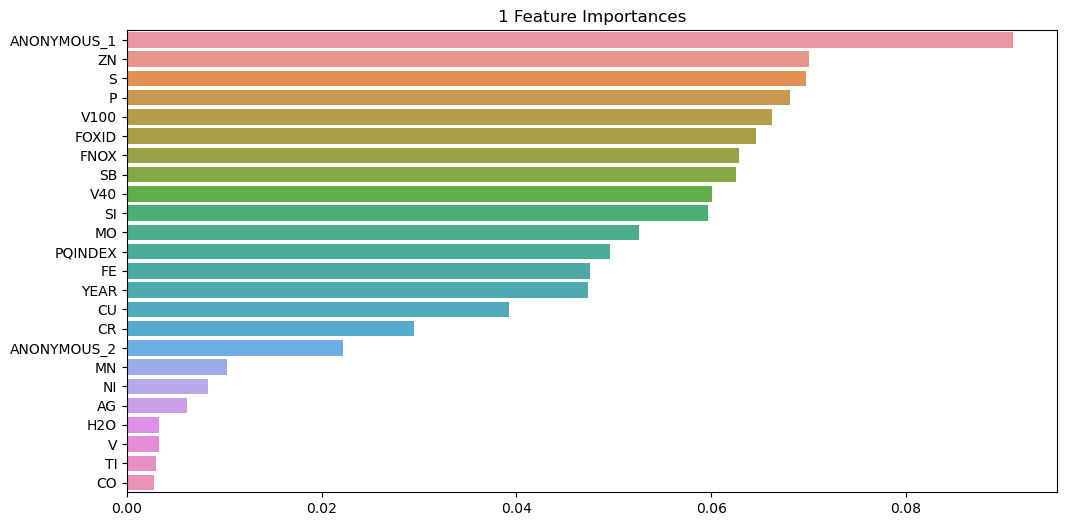

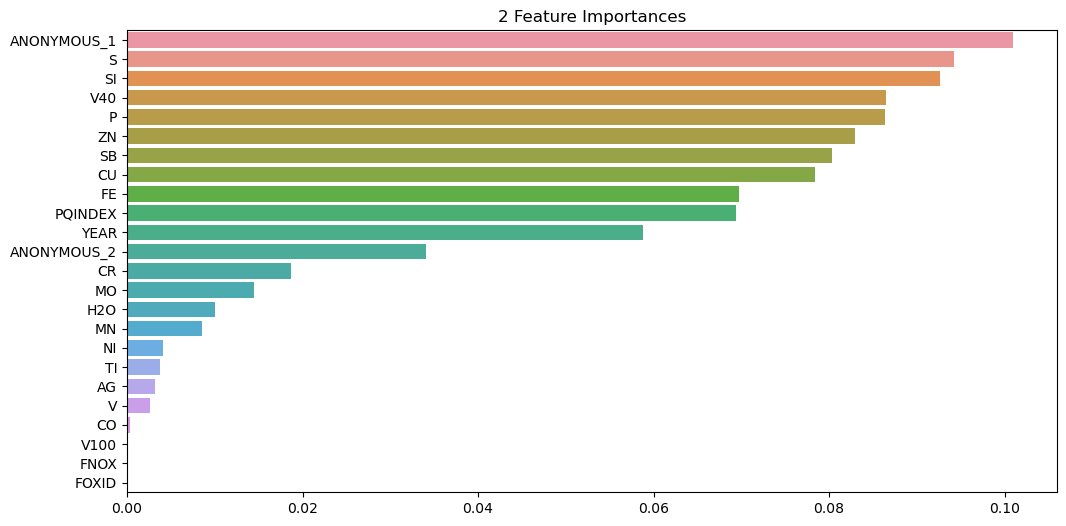

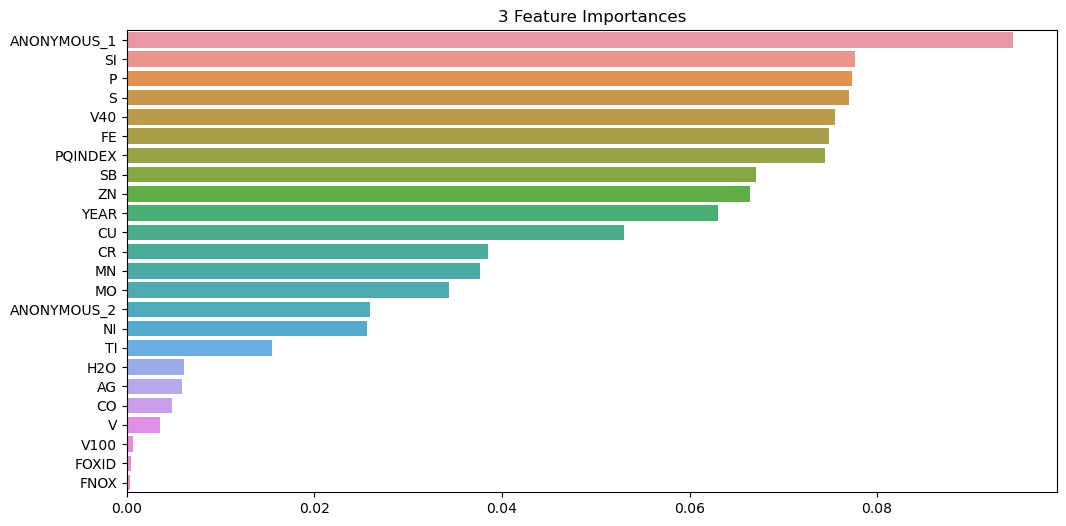

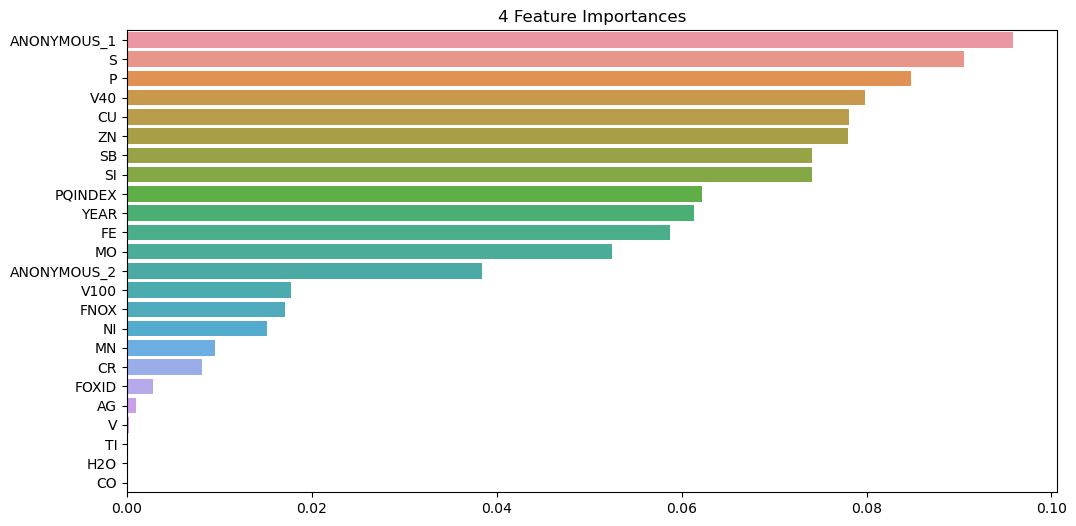


{1: [], 2: ['FNOX', 'FOXID'], 3: [], 4: []}



In [174]:
features_dict = balancing.feature_importance_for_groups(split_X_y_bundle)
drop_target_dict = choose_drop_features(features_dict, draw=True)

print()
print(drop_target_dict)
print()

['FNOX', 'FOXID', 'FSO4', 'FTBN', 'S', 'SB', 'SI', 'V100']

# Classification
- classifier hyper parameters

{
    
    "metric": , # 평가지표(default='r2_score')
    
    "learner": , # 학습모델['rf', 'xgb', 'lgbm'] 중 아무 조합 선택 ㄱㄱ(default=['rf', 'xgb', 'lgbm'])
    
    "ensemble": , # ['voting', 'stacking'](default='voting')
    
    "learning_rate": , # 학습률(default=0.05)
    
    "random_state": , # 난수 seed(default=42)
    
    "early_stopping_rounds": , # overfitting 방지용(default=10)
    
    "optimize": , # optuna 사용할지 말지 True or False 사용 ㄱㄱ(default=False)
    
    "n_trials": , # optuna 횟수(default=20)
    
    "cv": , # K-fold CV의 K(default=5)
    
    "N": , # voting에서 모델별 weights의 조합가지수(default=5)
    
}

******************** Component 1 ********************
Train F1_score is 0.9079
Validation F1_score is 0.4706
Test F1_score is 0.2152
-----------------------------------------------------
<Confusion Matrix>
[[ 9 18]
 [ 9 12]]
clf precision:	0.4000
clf recall:	0.5714
clf f1_score:	0.4706
-----------------------------------------------------
<Confusion Matrix>


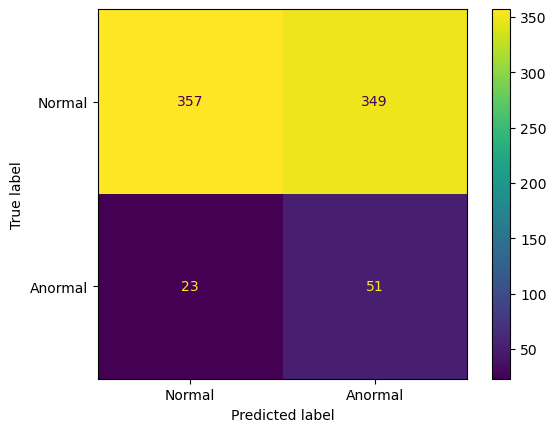

Final model precision:	0.1275
Final model recall:	0.6892
Final model f1_score:	0.2152
*****************************************************
******************** Component 2 ********************
Train F1_score is 0.9071
Validation F1_score is 0.5185
Test F1_score is 0.2429
-----------------------------------------------------
<Confusion Matrix>
[[11  5]
 [ 8  7]]
clf precision:	0.5833
clf recall:	0.4667
clf f1_score:	0.5185
-----------------------------------------------------
<Confusion Matrix>


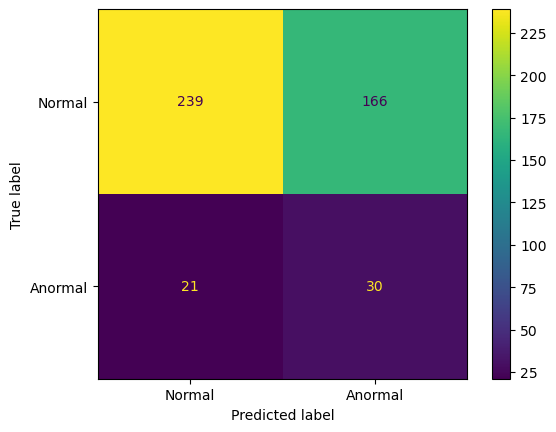

Final model precision:	0.1531
Final model recall:	0.5882
Final model f1_score:	0.2429
*****************************************************
******************** Component 3 ********************
Train F1_score is 0.9296
Validation F1_score is 0.6286
Test F1_score is 0.1805
-----------------------------------------------------
<Confusion Matrix>
[[32 16]
 [23 33]]
clf precision:	0.6735
clf recall:	0.5893
clf f1_score:	0.6286
-----------------------------------------------------
<Confusion Matrix>


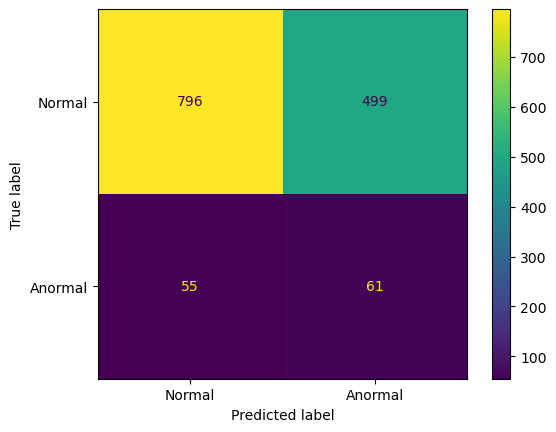

Final model precision:	0.1089
Final model recall:	0.5259
Final model f1_score:	0.1805
*****************************************************
******************** Component 4 ********************
Train F1_score is 0.9211
Validation F1_score is 0.2857
Test F1_score is 0.1250
-----------------------------------------------------
<Confusion Matrix>
[[3 5]
 [0 1]]
clf precision:	0.1667
clf recall:	1.0000
clf f1_score:	0.2857
-----------------------------------------------------
<Confusion Matrix>


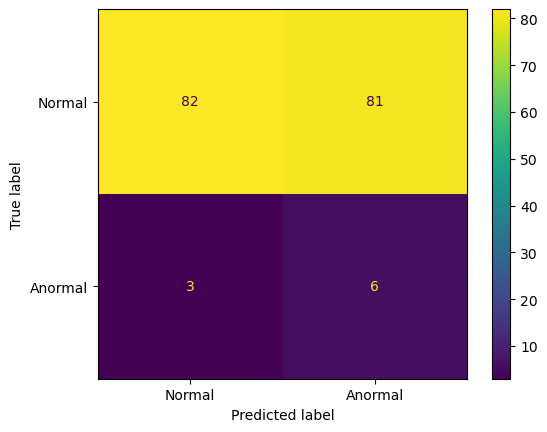

Final model precision:	0.0690
Final model recall:	0.6667
Final model f1_score:	0.1250
*****************************************************


In [149]:
test_final = pd.DataFrame()
val_final = pd.DataFrame()
X_y_union = pd.concat([X_test, y_test], axis=1)

for criterion, drop_target_list in drop_target_dict.items():
    X_train, X_val, y_train, y_val = split_X_y_bundle[criterion]
    
    X_train = X_train.drop(columns=drop_target_list)
    X_val = X_val.drop(columns=drop_target_list)
    
    test_temp = test[test.COMPONENT_ARBITRARY == criterion].drop(columns=drop_target_list)
    test_temp = test_temp.drop(columns=['COMPONENT_ARBITRARY'])
    
    X_test_temp = X_y_union[X_y_union.COMPONENT_ARBITRARY == criterion].drop(columns=drop_target_list)
    X_test_temp = X_test_temp.drop(columns=['COMPONENT_ARBITRARY', 'Y_LABEL'])
    
    y_test_temp = X_y_union[X_y_union.COMPONENT_ARBITRARY == criterion].Y_LABEL
    
    # Syncronize columns order between X3 and test
    test_temp = test_temp[X_train.columns]
    X_test_temp = X_test_temp[X_train.columns]
    
    # model initializing
    clf = BinaryCalssifier(metric='f1_score',
                           learner=['rf'],
                           optimize=False,
                           n_trials=20,
                           cv=5,
                           N=5,
                           random_state=12)
    # model training
    clf.fit(X_train, y_train) # n_trials: optuna 조지는 정도 / cv: K-fold의 K값

    # prediction
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test_temp)
    
    # scoring
    score_train = clf.score(y_train, y_train_pred)
    score_val = clf.score(y_val, y_val_pred)
    score_test = clf.score(y_test_temp, y_test_pred)
    
    print(f'******************** Component {criterion} ********************')
    print("Train F1_score is %.4f" % (score_train))
    print("Validation F1_score is %.4f" % (score_val))
    print("Test F1_score is %.4f" % (score_test))

    # fill prediction value in test data
    test_temp['Y_LABEL'] = clf.predict(test_temp)
    test_final = pd.concat([test_final, test_temp], axis=0)

    # fill prediction value in dummy test data
    X_test_temp['Y_LABEL'] = y_test_pred
    val_final = pd.concat([val_final, X_test_temp], axis=0)
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    conf_matrix_test = confusion_matrix(y_test_temp, y_test_pred)
    
    print('-' * 53)
    print("<Confusion Matrix>")
    print(conf_matrix_val)
    print('clf precision:\t%.4f' % (precision_score(y_val, y_val_pred)))
    print('clf recall:\t%.4f' % (recall_score(y_val, y_val_pred)))
    print('clf f1_score:\t%.4f' % (f1_score(y_val, y_val_pred)))
    print('-' * 53)
    print("<Confusion Matrix>")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_test,
                                        display_labels = ['Normal', 'Anormal'])
    cm_display.plot()
    plt.show()
    print('Final model precision:\t%.4f' % (precision_score(y_test_temp, y_test_pred)))
    print('Final model recall:\t%.4f' % (recall_score(y_test_temp, y_test_pred)))
    print('Final model f1_score:\t%.4f' % (f1_score(y_test_temp, y_test_pred)))
    print('*' * 53)

test_final = test_final.sort_index()
val_final = val_final.sort_index()
y_pred = val_final.Y_LABEL.values

In [76]:
val_final

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FNOX,FOXID,FE,...,PQINDEX,S,SB,SI,TI,V,V100,V40,ZN,Y_LABEL
2,-0.173409,0.339881,-0.340760,-0.150214,-0.089633,-0.080416,-0.252497,NaN,NaN,-0.326655,...,-0.260552,-0.850382,-0.138095,-0.173602,-0.102635,-0.106550,NaN,-0.740886,-0.332215,0
5,-0.257376,-1.425737,0.295608,-0.150214,-0.089633,-0.010473,1.120081,NaN,NaN,0.697370,...,-0.056382,-0.332793,0.451683,-0.061991,-0.102635,-0.106550,NaN,-0.799341,0.801831,0
12,-0.016623,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,-0.229233,NaN,NaN,-0.277892,...,-0.256626,0.848659,-0.171064,-0.170735,-0.102635,-0.106550,NaN,0.476595,-1.054393,0
23,-0.256665,-1.425737,1.593797,-0.150214,3.092669,-0.080416,-0.221479,NaN,NaN,-0.291021,...,-0.260552,1.675830,0.176942,-0.130493,-0.102635,-0.106550,NaN,0.770887,-0.973524,0
24,-0.273980,-1.425737,-0.340760,-0.150214,-0.089633,-0.045445,-0.252497,1.290847,1.840165,-0.311651,...,-0.260552,-0.822256,0.103677,-0.135357,-0.102635,-0.106550,0.435882,-0.003141,1.243789,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14059,1.016835,-0.164581,-0.340760,-0.150214,3.092669,0.199358,-0.143932,NaN,NaN,0.294137,...,0.609134,0.311251,0.323470,0.017314,0.042348,1.996846,NaN,1.419942,-1.039348,1
14062,-0.268287,-0.921274,-0.340760,-0.150214,-0.089633,-0.045445,-0.260252,NaN,NaN,-0.013446,...,0.800217,1.323182,4.876852,-0.120100,-0.102635,-0.106550,NaN,0.811201,-0.994212,0
14076,0.327784,1.096575,-0.340760,-0.150214,-0.089633,-0.115388,-0.089649,-1.338530,-1.292618,-0.313527,...,-0.267096,-0.794467,-0.097800,-0.151126,-0.102635,-0.106550,-1.507361,-0.406280,1.019989,1
14083,-0.263306,-0.921274,-0.340760,-0.150214,-0.089633,-0.045445,-0.244743,0.155201,-0.091533,-0.291021,...,-0.263824,-0.897416,-0.171064,-0.136791,-0.102635,-0.106550,3.671012,0.397983,0.858251,1


In [77]:
test_final

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FNOX,FOXID,FE,...,PQINDEX,S,SB,SI,TI,V,V100,V40,ZN,Y_LABEL
0,-0.226304,0.592112,-0.340760,-0.150214,-0.089633,-0.115388,-0.260252,-1.041830,-1.436526,-0.311651,...,-0.265133,-0.798994,-0.171064,-0.161519,-0.102635,-0.10655,-1.709711,-0.363951,0.944762,0
1,-0.083512,-0.669043,-0.340760,-0.150214,-0.089633,-0.045445,-0.260252,NaN,NaN,0.187233,...,1.516121,0.750740,-0.134432,0.219288,0.042348,-0.10655,NaN,0.353638,-1.084484,0
2,-0.276115,-0.921274,-0.340760,-0.150214,-0.089633,-0.115388,-0.143932,NaN,NaN,-0.324780,...,-0.264479,-1.152073,-0.163738,-0.169557,-0.102635,-0.10655,NaN,-1.311328,0.235748,0
3,-0.413213,-1.173506,-0.340760,-0.150214,-0.089633,-0.010473,-0.236988,NaN,NaN,-0.028450,...,4.968037,1.510487,0.136646,-0.111141,-0.102635,-0.10655,NaN,0.674134,-0.930269,0
4,1.204694,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,-0.221479,NaN,NaN,-0.309776,...,-0.261207,-0.683102,-0.167401,-0.150409,-0.102635,-0.10655,NaN,-0.926330,-0.225017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.339683,0.087650,-0.340760,-0.150214,-0.089633,-0.010473,0.740102,NaN,NaN,1.629495,...,1.036452,-0.419649,-0.123442,-0.053544,-0.102635,-0.10655,NaN,-0.769106,1.080171,0
6037,0.233617,0.592112,-0.340760,-0.150214,-0.089633,0.059471,-0.252497,NaN,NaN,1.046214,...,0.181816,0.638960,-0.160074,0.075372,-0.102635,-0.10655,NaN,0.573349,-1.082603,0
6038,0.279633,0.087650,-0.340760,-0.150214,-0.089633,-0.115388,-0.268007,NaN,NaN,-0.234755,...,-0.226524,1.048644,0.019423,-0.156502,-0.102635,-0.10655,NaN,3.887155,-1.082603,0
6039,-0.422701,-0.164581,-0.340760,-0.150214,-0.089633,-0.115388,0.212784,NaN,NaN,-0.330406,...,-0.268405,-0.868935,-0.156411,-0.172578,-0.102635,-0.10655,NaN,-1.174261,-0.208091,1


## Confusion Matrix

In [ ]:
# conf_matrix = confusion_matrix(y_val, y_pred)

## Classification Metrics

In [ ]:
# print('*' * 40)
# print('Final model precision:\t%.4f' % (precision_score(y_test, y_pred)))
# print('Final model recall:\t%.4f' % (recall_score(y_test, y_pred)))
# print('Final model f1_score:\t%.4f' % (f1_score(y_test, y_pred)))
# print('*' * 40)

# Make submission file

In [ ]:
if 'submission_oil.csv' in os.listdir(save_path):
    count = 0
    for name in os.listdir(save_path):
        if 'submission_oil' in name:
            count += 1
    filename = f"submission_oil{count + 1}.csv"
else:
    filename = 'submission_oil.csv'

# Export submission file
submission.Y_LABEL = test_final.Y_LABEL
submission.to_csv(save_path + filename, index=False)